In [1]:
#!pip install tsfeatures

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import tsfeature as tsf
import sys
sys.path.append("../")

import pprint
from sklearn.decomposition import PCA
from kats.consts import TimeSeriesData
from statsmodels.tsa.seasonal import STL
from kats.utils.simulator import Simulator
from sklearn.preprocessing import StandardScaler
from kats.tsfeatures.tsfeatures import TsFeatures

import warnings
warnings.simplefilter(action='ignore')

C:\ProgramData\Anaconda3\envs\kats\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Ver con glob para carpeta local
df= pd.read_csv('notificaciones_clima_7_dias_COMBINADO_SEMANAL.csv', sep=';')
poblacion= pd.read_csv('Poblacion_Paraguay.csv', sep=',')

In [4]:
poblacion['#'] = poblacion['#'].str.upper()
poblacion.rename(columns = {'#':'Ciudad'}, inplace = True)

In [5]:
df

,anio,semana,distrito_notif,tmax,tmin,tmed,td,pres_est,pres_nm,prcp,hr,helio,nub,vmax_d,vmax_f,vmed,id_estacion,casos
0,2009,2,ASUNCION,29.7,20.5,23.9,16.85,1001.05,1010.55,2,68,6.6,4.5,??,??,??,86218,2
1,2009,2,FERNANDO DE LA MORA,38,24.6,29.2,22.1,998.3,1007.6,0,68,11.1,5,??,??,??,86218,1
2,2009,2,PEDRO JUAN CABALLERO,27.7,21.3,23.1,20.9,947,1008.3,32.6,88.5,1.85,6.5,??,??,??,86097,2
3,2009,2,YBY YAU,27.4,20.65,22.65,20.475,947.1,1008.5,16.775,88.5,2.875,6.5,??,??,??,86097,4
4,2009,2,YPANE,29,20.2,23.3,16,1001.6,1011.2,0,66,7.5,6,??,??,??,86218,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8482,2013,52,VILLA HAYES,35.46666667,24.48333333,29.86666667,21.86666667,998.2666667,1007.683333,2.133333333,65.16666667,10.61666667,4,14.66666667,2.126666667,1.308333333,86218,6
8483,2013,52,VILLETA,34.53333333,23.6,28.7,21.73333333,996.6666667,1006.1,0.1,67.66666667,7.866666667,3.333333333,14.33333333,1.573333333,0.786666667,86218,3
8484,2013,52,YAGUARON,35,22.8,29.7,23.4,995.3,1008.4,0,70,10,1,0,0,0,86221,1
8485,2013,52,YPACARAI,36,24,29.2,21.4,994.7,1007.9,0,65,10.7,1,18,1.11,0.28,86221,2


In [6]:
print("La cantidad de ciudades con casos es:", df['distrito_notif'].nunique())
print("La cantidad de ciudades con datos de población:", poblacion['Ciudad'].nunique())

La cantidad de ciudades con casos es: 238
La cantidad de ciudades con datos de población: 268


In [7]:
S1 = set(list(dict.fromkeys(df['distrito_notif'].tolist())))
S2 = set(list(dict.fromkeys(poblacion['Ciudad'].tolist())))
ciudades = S1.intersection(S2)
df

,anio,semana,distrito_notif,tmax,tmin,tmed,td,pres_est,pres_nm,prcp,hr,helio,nub,vmax_d,vmax_f,vmed,id_estacion,casos
0,2009,2,ASUNCION,29.7,20.5,23.9,16.85,1001.05,1010.55,2,68,6.6,4.5,??,??,??,86218,2
1,2009,2,FERNANDO DE LA MORA,38,24.6,29.2,22.1,998.3,1007.6,0,68,11.1,5,??,??,??,86218,1
2,2009,2,PEDRO JUAN CABALLERO,27.7,21.3,23.1,20.9,947,1008.3,32.6,88.5,1.85,6.5,??,??,??,86097,2
3,2009,2,YBY YAU,27.4,20.65,22.65,20.475,947.1,1008.5,16.775,88.5,2.875,6.5,??,??,??,86097,4
4,2009,2,YPANE,29,20.2,23.3,16,1001.6,1011.2,0,66,7.5,6,??,??,??,86218,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8482,2013,52,VILLA HAYES,35.46666667,24.48333333,29.86666667,21.86666667,998.2666667,1007.683333,2.133333333,65.16666667,10.61666667,4,14.66666667,2.126666667,1.308333333,86218,6
8483,2013,52,VILLETA,34.53333333,23.6,28.7,21.73333333,996.6666667,1006.1,0.1,67.66666667,7.866666667,3.333333333,14.33333333,1.573333333,0.786666667,86218,3
8484,2013,52,YAGUARON,35,22.8,29.7,23.4,995.3,1008.4,0,70,10,1,0,0,0,86221,1
8485,2013,52,YPACARAI,36,24,29.2,21.4,994.7,1007.9,0,65,10.7,1,18,1.11,0.28,86221,2


In [8]:
df = df[['anio','distrito_notif', 'semana', 'casos']]


In [9]:
df.rename(columns = {'anio':'Año', 'distrito_notif':'Distrito'}, inplace = True)
df = df[df['Distrito'].isin(ciudades)]
listaDistrito = df['Distrito'].tolist()
listaDistrito = list(dict.fromkeys(listaDistrito))
print(listaDistrito)

['ASUNCION', 'FERNANDO DE LA MORA', 'PEDRO JUAN CABALLERO', 'YPANE', 'CAPIATA', 'CAPITAN BADO', 'HORQUETA', 'BELEN', 'CONCEPCION', 'LAMBARE', 'BELLA VISTA', 'HERNANDARIAS', 'ITAKYRY', 'ITAUGUA', 'CORONEL OVIEDO', 'LOMA PLATA', 'LUQUE', 'MCAL. ESTIGARRIBIA', 'MINGA GUAZU', 'PIRAYU', 'SAN ALBERTO', 'VILLA ELISA', 'YAGUARON', 'YPACARAI', 'CAACUPE', 'EMBOSCADA', 'ITA', 'LIMPIO', 'MARIANO ROQUE ALONSO', 'SAN LORENZO', 'VILLETA', 'GUARAMBARE', 'SAN JOSE DE LOS ARROYOS', 'CAAGUAZU', 'LORETO', 'NUEVA ITALIA', 'VILLA HAYES', 'ACAHAY', 'CARAPEGUA', 'CHORE', 'ENCARNACION', 'FRAM', 'JOSE DOMINGO OCAMPOS', 'PARAGUARI', 'REPATRIACION', 'SAN ANTONIO', 'SAN JUAN NEPOMUCENO', 'SANTA ROSA', 'LOMA GRANDE', 'SAN BERNARDINO', 'SAN ESTANISLAO', 'AREGUA', 'ARROYOS Y ESTEROS', 'EUSEBIO AYALA', 'ITACURUBI DE LA CORDILLERA', 'LA PALOMA', 'MINGA PORA', 'PILAR', 'SALTO DEL GUAIRA', 'SAN PEDRO', 'VILLARRICA', 'ALBERDI', 'CAMBYRETA', 'NATALIO', 'NUEVA ALBORADA', 'OBLIGADO', 'SAN JUAN BAUTISTA', 'SANTA RITA', 'TOBAT

In [10]:
poblacion

,Ciudad,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
0,TOTAL PAIS,5.284480e+06,5.385002e+06,5.484610e+06,5.583484e+06,5.681872e+06,5.779769e+06,5.877323e+06,5.974666e+06,6.071781e+06,...,6.854536e+06,6.953646e+06,7.052983e+06,7.152703e+06,7.252672e+06,7.353038e+06,7.453695e+06,7.554796e+06,7.656215e+06,7.758263e+06
1,ASUNCION,5.277120e+05,5.288654e+05,5.298028e+05,5.305652e+05,5.311534e+05,5.315611e+05,5.317809e+05,5.318310e+05,5.317012e+05,...,5.252935e+05,5.241895e+05,5.231840e+05,5.222868e+05,5.215588e+05,5.211012e+05,5.209174e+05,5.210911e+05,5.216305e+05,5.226158e+05
2,DPTO. CONCEPCION,1.899270e+05,1.927995e+05,1.956693e+05,1.985528e+05,2.014618e+05,2.044011e+05,2.073865e+05,2.104351e+05,2.135382e+05,...,2.404950e+05,2.440706e+05,2.476747e+05,2.513143e+05,2.549764e+05,2.586534e+05,2.623601e+05,2.660717e+05,2.698049e+05,2.735787e+05
3,CONCEPCION,6.332317e+04,6.438022e+04,6.543775e+04,6.650114e+04,6.757426e+04,6.865869e+04,6.975972e+04,7.088303e+04,7.202569e+04,...,8.191731e+04,8.322622e+04,8.454509e+04,8.587617e+04,8.721499e+04,8.855878e+04,8.991247e+04,9.126750e+04,9.262943e+04,9.400464e+04
4,BELEN,9.613559e+03,9.773428e+03,9.933309e+03,1.009402e+04,1.025614e+04,1.041991e+04,1.058613e+04,1.075566e+04,1.092806e+04,...,1.241835e+04,1.261527e+04,1.281363e+04,1.301377e+04,1.321500e+04,1.341691e+04,1.362024e+04,1.382371e+04,1.402815e+04,1.423453e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,DPTO. ALTO PARAGUAY,5.887000e+03,5.980193e+03,6.076836e+03,6.175847e+03,6.278555e+03,6.384460e+03,6.493927e+03,6.607088e+03,6.724518e+03,...,7.821606e+03,7.981708e+03,8.147389e+03,8.319021e+03,8.496212e+03,8.677771e+03,8.863892e+03,9.054662e+03,9.249617e+03,9.448388e+03
800,FUERTE OLIMPO,1.550795e+03,1.572313e+03,1.594523e+03,1.617134e+03,1.640487e+03,1.664442e+03,1.689087e+03,1.714447e+03,1.740664e+03,...,1.981016e+03,2.015560e+03,2.051187e+03,2.087976e+03,2.125816e+03,2.164400e+03,2.203765e+03,2.243926e+03,2.284757e+03,2.326160e+03
801,PUERTO CASADO,1.598532e+03,1.650988e+03,1.705354e+03,1.761364e+03,1.819427e+03,1.879441e+03,1.941550e+03,2.005833e+03,2.072511e+03,...,2.699127e+03,2.790936e+03,2.886086e+03,2.984769e+03,3.086901e+03,3.192099e+03,3.300469e+03,3.412083e+03,3.526801e+03,3.644509e+03
802,BAHIA NEGRA,1.033159e+03,1.033957e+03,1.034978e+03,1.036022e+03,1.037300e+03,1.038712e+03,1.040303e+03,1.042077e+03,1.044106e+03,...,1.067792e+03,1.071851e+03,1.076147e+03,1.080706e+03,1.085456e+03,1.090226e+03,1.095028e+03,1.099861e+03,1.104658e+03,1.109365e+03


In [11]:
pob= []
for year in list(range(2009,2014)):
    aux = df[df['Año'] == year]
    for dis in aux.Distrito.values:
        pob.append(int(poblacion[poblacion.Ciudad == dis][str(year)].values[0]))   
print(len(pob))

6921


In [1]:
df['Poblacion'] = pob
df

NameError: name 'pob' is not defined

In [13]:
df['incidencia'] = (df.casos/df.Poblacion)*100000
df

,Año,Distrito,semana,casos,Poblacion,incidencia
0,2009,ASUNCION,2,2,531388,0.376373
1,2009,FERNANDO DE LA MORA,2,1,143116,0.698734
2,2009,PEDRO JUAN CABALLERO,2,2,103243,1.937177
4,2009,YPANE,2,1,36547,2.736203
5,2009,ASUNCION,3,1,531388,0.188186
...,...,...,...,...,...,...
8482,2013,VILLA HAYES,52,6,46033,13.034128
8483,2013,VILLETA,52,3,33890,8.852169
8484,2013,YAGUARON,52,1,30369,3.292832
8485,2013,YPACARAI,52,2,25002,7.999360


In [14]:
df['semana'] = df['semana'] + df['Año'].apply(lambda x: (x-2009)*53 if x>2009 else 0)

In [15]:
df.reset_index(drop=True)

,Año,Distrito,semana,casos,Poblacion,incidencia
0,2009,ASUNCION,2,2,531388,0.376373
1,2009,FERNANDO DE LA MORA,2,1,143116,0.698734
2,2009,PEDRO JUAN CABALLERO,2,2,103243,1.937177
3,2009,YPANE,2,1,36547,2.736203
4,2009,ASUNCION,3,1,531388,0.188186
...,...,...,...,...,...,...
6916,2013,VILLA HAYES,264,6,46033,13.034128
6917,2013,VILLETA,264,3,33890,8.852169
6918,2013,YAGUARON,264,1,30369,3.292832
6919,2013,YPACARAI,264,2,25002,7.999360


In [16]:
def run_length_encoding(x):
    """
    :param x: np.array
    :return: np.array
    """
    pos, = np.where(np.diff(x) != 0)
    pos = np.concatenate(([0], pos+1, [len(x)]))
    # rle = [(a,b,x[a]) for (a,b) in zip(pos[:-1],pos[1:])]
    rle = [b - a for (a, b) in zip(pos[:-1], pos[1:])]
    return rle


def hysteresis(x, th_lo, th_hi, initial=False):
    """
    :param x: np.array
    :param th_lo: float
    :param th_hi: float
    :param initial: ???
    :return:
    """
    hi = x >= th_hi
    lo_or_hi = (x <= th_lo) | hi
    ind = np.nonzero(lo_or_hi)[0]
    # prevent index error if ind is empty
    if not ind.size:
        return np.zeros_like(x, dtype=bool) | initial
    # from 0 to len(x)
    cnt = np.cumsum(lo_or_hi)
    return np.where(cnt, hi[ind[cnt-1]], initial)


def arg_longest_not_null(x):
    # pad with np.nan while finding where null
    m = np.concatenate(( [True], np.isnan(x), [True] ))
    # Start-stop limits
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)
    # Get max interval, interval limits
    start, stop = ss[(ss[:,1] - ss[:,0]).argmax()]
    return start, stop

In [17]:
class poly(object):
    """ Orthogonal polynomials

    Source:
        http://davmre.github.io/python/2013/12/15/orthogonal_poly
    """

    def __init__(self):
        self.degree = None
        self.z = None
        self.norm2 = None
        self.alpha = None

    def fit(self, x, degree=1):

        self.degree = degree

        n = degree + 1
        x = np.asarray(x).flatten()
        if degree >= len(np.unique(x)):
            raise ValueError("'degree' must be less than number of unique points")

        xbar = np.mean(x)
        x = x - xbar
        q, r = np.linalg.qr(np.fliplr(np.vander(x, n)))

        z = np.diag(np.diag(r))
        raw = np.dot(q, z)

        norm2 = np.sum(raw**2, axis=0)
        alpha = (np.sum((raw**2)*np.reshape(x, (-1, 1)), axis=0)/norm2 + xbar)[:degree]
        z = raw / np.sqrt(norm2)

        self.z = z
        self.norm2 = norm2
        self.alpha = alpha

    def predict(self, x):
        x = np.asarray(x).flatten()
        n = self.degree + 1
        z = np.empty((len(x), n))
        z[:, 0] = 1

        if self.degree > 0:
            z[:, 1] = x - self.alpha[0]

        if self.degree > 1:
            for i in np.arange(1, self.degree):
                z[:, i+1] = (x - self.alpha[i]) * z[:, i] - (self.norm2[i] / self.norm2[i-1]) * z[:, i-1]

        z /= np.sqrt(self.norm2)

        return z

# Fig Func

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale as scale_data


def biplot_features(x, robust=False, scale=True,  col=None, **kwargs):
    X = x.dropna(axis=1, how='all').dropna(axis=0, how='any')

    if col is None:
        col = ("#000000", "darkred")
    else:
        col = [col] if not isinstance(col, (list, tuple)) else col
        col = np.unique(col)

        if len(col) == 1:
            col = np.repeat(col, 2)
        else:
            col = np.unique(col)[0:2]

    if scale:
        X = scale_data(X, with_mean=True, with_std=True)

    if robust:
        raise NotImplemented('Robust PCA has not been implemented yet')
    else:
        pca = PCA(n_components=2)
        pca.fit(X)
        proj_pca = pca.transform(X)

    plt.figure()
    plt.scatter(x=proj_pca[:, 0], y=proj_pca[:, 1], c=col)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

In [19]:
import statsmodels.api as sm

from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.stats import boxcox_normmax
from statsmodels.sandbox.gam import AdditiveModel

try:
    from entropy import spectral_entropy
except ImportError:
    ENTROPY_PACKAGE_AVAILABLE = False
else:
    ENTROPY_PACKAGE_AVAILABLE = True

# features_hyndman
# https://github.com/robjhyndman/anomalous/blob/master/R/tsmeasures.R

_VARIABLE_COUNT = 0


def trim(x, trim=0.1):
    """Trimmed time series eliminating outliers's influence"""
    qtl = x.quantile([trim, 1 - trim])
    lo = qtl.iloc[0]
    hi = qtl.iloc[1]

    trim_x = x.copy()
    trim_x[(trim_x < lo) | (trim_x > hi)] = np.nan
    return trim_x


def first_order_autocorrelation(x):
    """First order of autocorrelation"""
    return x.autocorr(1)


def lumpiness(x, width):
    """Lumpiness

    Note:
        Cannot be used for yearly data
    """
    nr = len(x)
    start = np.arange(1, nr, step=width, dtype=int)
    end = np.arange(width, nr + width, step=width, dtype=int)

    nsegs = int(nr / width)

    varx = np.zeros(nsegs)

    for idx in range(nsegs):
        tmp = x[start[idx]:end[idx]]
        varx[idx] = tmp[~np.isnan(tmp)].var()

    lump = varx[~np.isnan(varx)].var()
    return lump


def rolling_level_shift(x, width):
    """Level shift

    Using rolling window
    """

    tmp = x.dropna()
    roll_mean = tmp.rolling(width).mean()

    try:
        level_shifts = roll_mean.diff(width).abs().max()
    except Exception:
        level_shifts = np.nan

    return level_shifts


def rolling_variance_change(x, width):
    """Variance change

    Using rolling window

    """
    tmp = x.dropna()

    roll_var = tmp.rolling(width).var()

    try:
        variance_change = roll_var.diff(width).abs().max()
    except Exception:
        variance_change = np.nan

    return variance_change


def n_crossing_points(x):
    """Number of crossing points"""
    mid_line = ((x.max() - x.min()) / 2.0)
    ab = (x <= mid_line).values
    len_x = len(x)
    p1 = ab[1:(len_x - 1)]
    p2 = ab[2:len_x]
    cross = (p1 & ~p2) | (p2 & ~p1)
    return cross.sum()


def flat_spots(x):
    """Flat spots using discretization"""

    try:
        cut_x = pd.cut(x, bins=10, include_lowest=True, labels=False)
        rle_x = run_length_encoding(cut_x)
        spots = max(rle_x)
    except Exception:
        spots = np.nan

    #  Any flat spot
    return spots


def trend_seasonality_spike_strength(x, freq):
    """Strength of trend and seasonality and spike"""
    cont_x = x.dropna()
    length_cont_x = len(cont_x)
    season = peak = trough = np.nan

    if length_cont_x < (2 * freq):
        trend = linearity = curvature = season = spike = peak = trough = np.nan
    else:

        if freq > 1:
            all_stl = sm.tsa.seasonal_decompose(cont_x, freq=freq)
            trend0 = all_stl.trend
            fits = trend0 + all_stl.seasonal
            adj_x = cont_x - fits
            v_adj = adj_x.var()
            detrend = cont_x - trend0
            deseason = cont_x - all_stl.seasonal
            peak = all_stl.seasonal.max()
            trough = all_stl.seasonal.min()
            remainder = all_stl.resid
            season = 0 if detrend.var() < 1e-10 else max(0, min(1, 1 - v_adj/detrend.var()))

        else:  # No seasonal component
            tt = np.array([range(length_cont_x)]).T

            _trend0_values = AdditiveModel(tt).fit(cont_x.values).mu
            trend0=pd.Series(_trend0_values, index=cont_x.index)
            remainder = cont_x - trend0
            deseason = cont_x - trend0
            v_adj = trend0.var()

        trend = 0 if deseason.var() < 1e-10 else max(0, min(1, 1 - v_adj/deseason.var()))

        n = len(remainder)
        v = remainder.var()
        d = (remainder - remainder.mean())**2
        varloo = (v * (n - 1) - d) / (n - 2)
        spike = varloo.var()
        pl = poly()
        pl.fit(range(length_cont_x), degree=2)
        result_pl = pl.predict(range(length_cont_x))  # [:, 2]

        X = sm.add_constant(result_pl, has_constant='add')
        ols_data = trend0.copy()
        ols_data = pd.concat([ols_data.reset_index(drop=True), pd.DataFrame(X)], axis=1, ignore_index=True)
        ols_data.columns = ['Y', 'Intercept', 'X1', 'X2', 'X3']
        result_ols = ols('Y ~ X1 + X2 + X3', data=ols_data.dropna())

        trend_coef = result_ols.fit().params
        linearity = trend_coef[1]
        curvature = trend_coef[2]

    result = dict(trend=trend, spike=spike, peak=peak, trough=trough, linearity=linearity, curvature=curvature)

    if freq > 1:
        result["season"] = season

    return result


def kullback_leibler_score(x, window, threshold=None):
    """Kullback-Leibler score"""

    if threshold is None:
        threshold = norm.pdf(38)

    gw = 100  # grid width
    xgrid = np.arange(x.min(), x.max(), step=(x.max() - x.min()) / gw, dtype=float)
    grid = xgrid[1] - xgrid[0]
    tmpx = x[~x.isnull()]  # Remove NA to calculate bw
    bw = gaussian_kde(tmpx).covariance_factor()
    len_x = len(x)

    if len_x <= (2 * window):
        raise ValueError("Cannot compute KLscore when the length is too small.")

    dens_mat = np.zeros((len_x, gw))

    for i in range(len_x):
        dens_mat[i, :] = norm.pdf(xgrid, x[i], bw)

    dens_mat = np.clip(dens_mat, threshold, None)

    rmean = dens_mat.rolling(window=window).mean()

    lo = range(len_x - window + 1)
    hi = range(window + 1, len_x)
    seqidx = min(len(lo), len(hi))

    kl = np.zeros(seqidx)
    for i in range(seqidx):
        kl[i] = np.sum(rmean[lo[i], ] * (np.log(rmean[lo[i], ]) - np.log(rmean[hi[i], ])) * grid)

    diffkl = pd.Series(kl).dropna().diff()
    maxidx = np.argmax(diffkl)

    return dict(score=np.max(diffkl), change_idx=maxidx)


def boxcox_optimal_lambda(x):
    y = x + 0.0000001 if np.any(x == 0) else x
    return boxcox_normmax(y)


# TODO: implement Spectral Entropy
def entropy(x, freq=1, normalize=False):
    """
    Spectral Entropy
    """
    try:
        start, stop = arg_longest_not_null(x)
        result = spectral_entropy(x[start:stop], sf=freq, method='welch', normalize=normalize)
    except Exception:
        result = np.nan
    finally:
        return result


def ts_measures(x, freq=1, normalize=True, width=None, window=None):
    """
    See `ts_measures_series` doc
    """

    if isinstance(x, pd.Series):
        measures_df = ts_measures_series(x, freq=freq, normalize=normalize, width=width, window=window)
    elif isinstance(x, pd.DataFrame):
        _buffer = []
        for c in x.columns:
            _buffer.append(ts_measures_series(x[c], freq=freq, normalize=normalize, width=width, window=window))
        measures_df = pd.concat(_buffer, axis=0)

    elif issubclass(x.__class__, pd.core.groupby._GroupBy):
        _buffer = []
        for i in x.groups:
            _buffer.append(ts_measures(x.get_group(i), freq=freq, normalize=normalize, width=width, window=window))

        measures_df = pd.concat(_buffer, axis=0)
    else:
        raise TypeError('Unhandled input type')

    return measures_df


def ts_measures_series(x, freq=1, normalize=True, width=None, window=None):
    """
    :param x: a uni-variate time series
    :param freq: number of points to be considered as part of a single period for trend_seasonality_spike_strength
    :param normalize: TRUE: scale data to be normally distributed
    :param width: a window size for variance change and level shift, lumpiness
    :param window: a window size for KLscore
    :return:
    """
    name = x.name

    if width is None:
        width = freq if freq > 1 else 10

    if window is None:
        window = width

    if (width <= 1) | (window <= 1):
        raise ValueError("Window widths should be greater than 1.")

    # Remove columns containing all NAs
    if x.isnull().all():
        raise ValueError("All values are null")

    if normalize:
        x = (x - np.min(x)) / (np.max(x) - np.min(x))

    trimx = trim(x)

    measures = dict()
    measures['lumpiness'] = lumpiness(x, width=width)
    if ENTROPY_PACKAGE_AVAILABLE:
        measures['entropy'] = entropy(x, freq=freq, normalize=False)
    measures['ACF1'] = first_order_autocorrelation(x)
    measures['lshift'] = rolling_level_shift(trimx, width=width)
    measures['vchange'] = rolling_variance_change(trimx, width=width)
    measures['cpoints'] = n_crossing_points(x)
    measures['fspots'] = flat_spots(x)
    #  measures['mean'] = np.mean(x)
    #  measures['var'] = np.var(x)

    varts = trend_seasonality_spike_strength(x, freq=freq)
    measures['trend'] = varts['trend']
    measures['linearity'] = varts['linearity']
    measures['curvature'] = varts['curvature']
    measures['spikiness'] = varts['spike']

    if freq > 1:
        measures['season'] = varts['season']
        measures['peak'] = varts['peak']
        measures['trough'] = varts['trough']

    threshold = norm.pdf(38)

    try:
        kl = kullback_leibler_score(x, window=window, threshold=threshold)
        measures['KLscore'] = kl['score']
        measures['change_idx'] = kl['change_idx']
    except Exception:
        measures['KLscore'] = np.nan
        measures['change_idx'] = np.nan

    measures['boxcox'] = boxcox_optimal_lambda(x)

    # Build output
    measures_df = pd.Series(measures).to_frame().transpose()
    measures_df.index = [x.index.min()] if isinstance(x, pd.Series) else [0]
    measures_df['variable'] = name if name is not None else generate_name()
    return measures_df

def generate_name(prefix='var_'):
    global _VARIABLE_COUNT
    output = "{}{}".format(prefix, _VARIABLE_COUNT)
    _VARIABLE_COUNT += 1
    return output

In [20]:
i=0
df1 = df[['Distrito','semana', 'incidencia']]
for dis in listaDistrito:
    df1.loc[df1['Distrito']==dis,'ID_distrito']=i
    i=i+1
df1

,Distrito,semana,incidencia,ID_distrito
0,ASUNCION,2,0.376373,0.0
1,FERNANDO DE LA MORA,2,0.698734,1.0
2,PEDRO JUAN CABALLERO,2,1.937177,2.0
4,YPANE,2,2.736203,3.0
5,ASUNCION,3,0.188186,0.0
...,...,...,...,...
8482,VILLA HAYES,264,13.034128,36.0
8483,VILLETA,264,8.852169,30.0
8484,YAGUARON,264,3.292832,22.0
8485,YPACARAI,264,7.999360,23.0


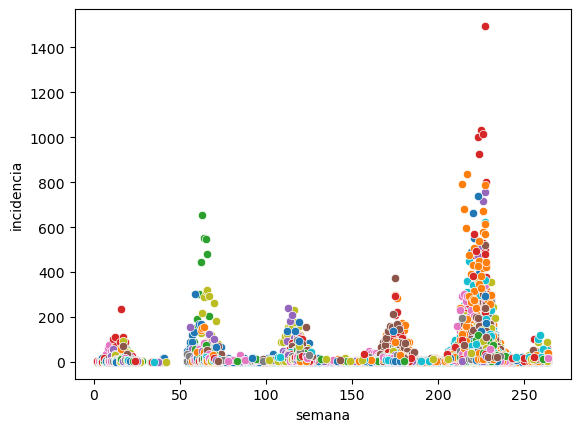

In [21]:
timeSeries = pd.DataFrame()
#listaDistrito = listaDistrito[0:15]
for dis in listaDistrito:
    distrito=df[df['Distrito']==dis]
    distrito.sort_values(['semana'], ascending = True)
    distrito = distrito.reset_index(drop=True)
    distrito = distrito.replace('nan', np.nan).fillna(0.00000000001)
    distrito = distrito.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)
    timeSeries = timeSeries.append(distrito['incidencia'], ignore_index=True)
    #print(dis)
    ax = sns.scatterplot(y=distrito['incidencia'], x= distrito['semana'])
plt.show()

In [22]:
#import tsfresh
#from tsfresh import extract_features

#features extraction
#extracted_features = extract_features(df1, column_id='ID_distrito', column_sort='semana', column_value='incidencia')

In [23]:
timeSeries = timeSeries.replace('nan', np.nan).fillna(0.00000000001)
timeSeries = timeSeries.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)

In [24]:
#df1

In [25]:
#from tsfeatures import tsfeatures
#df2 = df1[['ID_distrito', 'incidencia', 'semana']]
#df2 = df2.reset_index(drop=True)
#df2.rename(columns = {'ID_distrito':'unique_id', 'incidencia':'y', 'semana':'ds'}, inplace = True)

In [26]:
#timeSeries

In [27]:
#y = ts_measures(timeSeries.T)
#y.insert(0, "Distrito", listaDistrito, allow_duplicates=False)

In [28]:
model = TsFeatures()
output_features = [model.transform(ts) for ts in timeSeries.iterrows()]

ERROR:root:Length of time series is too short to calculate features


ValueError: Length of time series is too short to calculate features

In [30]:
features = pd.DataFrame()
Mean=[]
Var=[]
aCF1=[]
Trend=[]
Linearity=[]
Curvature=[]
#Season=[]
Peak=[]
Entropy=[]
Lumpiness=[]
Lshift=[]
Vchange=[]
Fspots=[]
Cpoints_ts=[]
Cpoints_JV=[]
Klscore=[]
ChangeIdx=[]

for dis in listaDistrito:
    distrito_1=df['Distrito']==dis
    casos_distrito1=df[distrito_1]
    casos_distrito1 = casos_distrito1.reset_index(drop=True)
    casos_distrito1 = casos_distrito1['incidencia']
    casos_distrito1 = casos_distrito1.replace('nan', np.nan).fillna(0.00000000001)
    casos_distrito1 = casos_distrito1.replace(0, np.nan).fillna(0.00000000001)
    casos_distrito1 = casos_distrito1.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)
    
    #Features
    mean=tsfresh.feature_extraction.feature_calculators.mean(casos_distrito1)
    var=tsfresh.feature_extraction.feature_calculators.variance(casos_distrito1)
    ACF1=tsfresh.feature_extraction.feature_calculators.autocorrelation(casos_distrito1,1)
    trend = y[y["Distrito"] == dis].trend
    linear = y[y["Distrito"] == dis].linearity
    curv = y[y["Distrito"] == dis].curvature
    #season = y[y["Distrito"] == dis].Seasonality
    peak=tsfresh.feature_extraction.feature_calculators.number_peaks(casos_distrito1,mean*2)
    entropy=tsfresh.feature_extraction.feature_calculators.sample_entropy(casos_distrito1)
    lump = y[y["Distrito"] == dis].lumpiness
    lshift = y[y["Distrito"] == dis].lshift
    vchange = y[y["Distrito"] == dis].vchange
    fspots = y[y["Distrito"] == dis].fspots
    cpoints_ts = tsfresh.feature_extraction.feature_calculators.number_crossing_m(casos_distrito1,mean)
    cpoints_jv = y[y["Distrito"] == dis].cpoints
    klscore = y[y["Distrito"] == dis].KLscore
    changeidx = y[y["Distrito"] == dis].change_idx
    
    Mean.append(mean)
    Var.append(var)
    aCF1.append(ACF1)
    Trend.append(trend[0])
    Linearity.append(linear[0])
    Curvature.append(curv[0])
    #Season.append(season[0])
    Peak.append(peak)
    Entropy.append(entropy)
    Lumpiness.append(lump[0])
    Lshift.append(lshift[0])
    Vchange.append(vchange[0])
    Fspots.append(fspots[0])
    Cpoints_ts.append(cpoints_ts)
    #Cpoints_JV.append(cpoints_jv[0])
    Klscore.append(klscore[0])
    ChangeIdx.append(changeidx[0])

In [31]:
#data_tuples = list(zip(Mean,Var,aCF1, Season, Trend, Linearity, Curvature, Peak, Entropy, Lumpiness, Lshift, Vchange, Fspots, Cpoints_ts, Cpoints_JV, Klscore, ChangeIdx))
#features = pd.DataFrame(data_tuples, columns =['Mean', 'Var', 'ACF1','Seasonality','Trend', 'Linearity', 'Curvature', 'Peak','Entropy','Lumpiness','Lshift', 'Vchange','Fspots', 'Cpoints_ts', 'Cpoints_JV', 'KlScore', 'ChangeIdx']) 

data_tuples = list(zip(Mean,Var,aCF1,Trend, Linearity, Curvature, Peak, Entropy, Lumpiness, Lshift, Vchange, Fspots, Cpoints_ts, Klscore, ChangeIdx))
features = pd.DataFrame(data_tuples, columns =['Mean', 'Var', 'ACF1','Trend', 'Linearity', 'Curvature', 'Peak','Entropy','Lumpiness','Lshift', 'Vchange','Fspots', 'Cpoints_ts', 'KlScore', 'ChangeIdx']) 
# print the data 
features

,Mean,Var,ACF1,Trend,Linearity,Curvature,Peak,Entropy,Lumpiness,Lshift,Vchange,Fspots,Cpoints_ts,KlScore,ChangeIdx
0,0.069045,0.005239,0.813519,0.493841,0.002839,-0.814313,0,0.597837,0.000085,0.011594,0.000059,172.0,0,NaN,NaN
1,0.447816,0.484126,0.937123,0.674731,0.007558,0.366222,3,0.169891,0.000056,0.198215,0.015514,49.0,0,NaN,NaN
2,0.448191,1.042302,0.928575,0.965372,0.004119,-0.340767,3,0.131780,0.001012,0.065305,0.002041,58.0,2,NaN,NaN
3,0.596768,1.191727,0.910305,0.812081,0.005702,-0.147679,2,0.152475,0.000510,0.137692,0.004926,84.0,4,NaN,NaN
4,0.495950,1.383553,0.925731,0.727396,0.004146,0.398613,2,0.088316,0.000287,0.057100,0.001377,79.0,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,0.312045,0.010819,-1.000000,0.849019,0.000552,-0.184931,0,NaN,0.000038,0.000000,0.000000,192.0,0,NaN,NaN
183,0.333333,0.000000,NaN,0.919391,0.000368,-0.123715,0,NaN,0.000000,0.000000,0.000000,193.0,0,NaN,NaN
184,0.271297,0.000000,NaN,0.919391,0.000368,-0.123715,0,NaN,0.000000,0.000000,0.000000,193.0,0,NaN,NaN
185,0.235405,0.000000,NaN,0.737090,0.001105,-0.367298,0,inf,0.001885,0.000000,0.000000,191.0,0,NaN,NaN


In [32]:
features.insert(0, 'Distrito', y.Distrito.values)
features

,Distrito,Mean,Var,ACF1,Trend,Linearity,Curvature,Peak,Entropy,Lumpiness,Lshift,Vchange,Fspots,Cpoints_ts,KlScore,ChangeIdx
0,ASUNCION,0.069045,0.005239,0.813519,0.493841,0.002839,-0.814313,0,0.597837,0.000085,0.011594,0.000059,172.0,0,NaN,NaN
1,FERNANDO DE LA MORA,0.447816,0.484126,0.937123,0.674731,0.007558,0.366222,3,0.169891,0.000056,0.198215,0.015514,49.0,0,NaN,NaN
2,PEDRO JUAN CABALLERO,0.448191,1.042302,0.928575,0.965372,0.004119,-0.340767,3,0.131780,0.001012,0.065305,0.002041,58.0,2,NaN,NaN
3,YPANE,0.596768,1.191727,0.910305,0.812081,0.005702,-0.147679,2,0.152475,0.000510,0.137692,0.004926,84.0,4,NaN,NaN
4,CAPIATA,0.495950,1.383553,0.925731,0.727396,0.004146,0.398613,2,0.088316,0.000287,0.057100,0.001377,79.0,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,LEANDRO OVIEDO,0.312045,0.010819,-1.000000,0.849019,0.000552,-0.184931,0,NaN,0.000038,0.000000,0.000000,192.0,0,NaN,NaN
183,ISLA UMBU,0.333333,0.000000,NaN,0.919391,0.000368,-0.123715,0,NaN,0.000000,0.000000,0.000000,193.0,0,NaN,NaN
184,VILLA OLIVA,0.271297,0.000000,NaN,0.919391,0.000368,-0.123715,0,NaN,0.000000,0.000000,0.000000,193.0,0,NaN,NaN
185,CARMELO PERALTA,0.235405,0.000000,NaN,0.737090,0.001105,-0.367298,0,inf,0.001885,0.000000,0.000000,191.0,0,NaN,NaN


In [33]:
features = features.replace('nan', np.nan).fillna(0.00000000001)
features = features.replace(0, np.nan).fillna(0.00000000001)
features = features.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)
features

,Distrito,Mean,Var,ACF1,Trend,Linearity,Curvature,Peak,Entropy,Lumpiness,Lshift,Vchange,Fspots,Cpoints_ts,KlScore,ChangeIdx
0,ASUNCION,0.069045,5.239362e-03,8.135193e-01,0.493841,0.002839,-0.814313,1.000000e-11,5.978370e-01,8.533764e-05,1.159420e-02,5.892786e-05,172.0,1.000000e-11,1.000000e-11,1.000000e-11
1,FERNANDO DE LA MORA,0.447816,4.841265e-01,9.371226e-01,0.674731,0.007558,0.366222,3.000000e+00,1.698908e-01,5.627058e-05,1.982146e-01,1.551413e-02,49.0,1.000000e-11,1.000000e-11,1.000000e-11
2,PEDRO JUAN CABALLERO,0.448191,1.042302e+00,9.285754e-01,0.965372,0.004119,-0.340767,3.000000e+00,1.317796e-01,1.012494e-03,6.530483e-02,2.040934e-03,58.0,2.000000e+00,1.000000e-11,1.000000e-11
3,YPANE,0.596768,1.191727e+00,9.103049e-01,0.812081,0.005702,-0.147679,2.000000e+00,1.524750e-01,5.098822e-04,1.376919e-01,4.925691e-03,84.0,4.000000e+00,1.000000e-11,1.000000e-11
4,CAPIATA,0.495950,1.383553e+00,9.257310e-01,0.727396,0.004146,0.398613,2.000000e+00,8.831604e-02,2.872938e-04,5.709974e-02,1.376932e-03,79.0,4.000000e+00,1.000000e-11,1.000000e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,LEANDRO OVIEDO,0.312045,1.081912e-02,-1.000000e+00,0.849019,0.000552,-0.184931,1.000000e-11,1.000000e-11,3.847338e-05,1.000000e-11,1.000000e-11,192.0,1.000000e-11,1.000000e-11,1.000000e-11
183,ISLA UMBU,0.333333,1.000000e-11,1.000000e-11,0.919391,0.000368,-0.123715,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e-11,193.0,1.000000e-11,1.000000e-11,1.000000e-11
184,VILLA OLIVA,0.271297,1.000000e-11,1.000000e-11,0.919391,0.000368,-0.123715,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e-11,1.000000e-11,193.0,1.000000e-11,1.000000e-11,1.000000e-11
185,CARMELO PERALTA,0.235405,1.000000e-11,1.000000e-11,0.737090,0.001105,-0.367298,1.000000e-11,1.000000e-11,1.885195e-03,1.000000e-11,1.000000e-11,191.0,1.000000e-11,1.000000e-11,1.000000e-11


In [34]:
features.to_csv('15Features_2009al2013_Incidencia.csv')

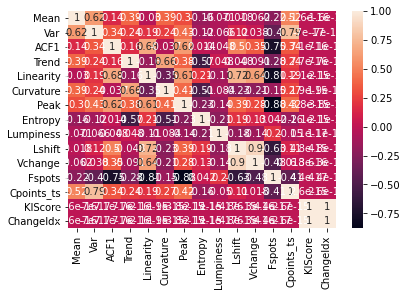

In [35]:
corr_df = features.corr()
#print("The correlation DataFrame is:")
#print(corr_df, "\n")
sns.heatmap(corr_df, annot=True)
plt.show()

In [36]:
n= timeSeries.shape[0]
n

187

# Funciones de Distancias

In [37]:
import math
from math import sqrt, log, floor
from sklearn.metrics import mean_squared_error
from statistics import mean
from fastdtw import fastdtw
from scipy import stats
from scipy.spatial.distance import pdist

#Euclidean
def euclidean(x, y):
    r=np.linalg.norm(x-y)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Fast Dynamic time warping
def fast_DTW(x, y):
    r, _ = fastdtw(x, y, dist=euclidean)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Spearman
def scorr(x, y):
    r = stats.spearmanr(x, y)[0]
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

#RMSE
def rmse(x, y):
    r=sqrt(mean_squared_error(x,y))
    if math.isnan(r):
        r=1
    #print(r)
    return r

def lcs(a, b):  
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    x, y = len(a), len(b)
    result = lengths[x][y]
    return result

def discretise(x):
    return int(x * 10)

def multidim_lcs(a, b):
    a = a.applymap(discretise)
    b = b.applymap(discretise)
    rows, dims = a.shape
    lcss = [lcs(a[i+2], b[i+2]) for i in range(dims)]
    return 1 - sum(lcss) / (rows * dims)

#Correlation
def corr(x, y):
    r=np.dot(x-mean(x),y-mean(y))/((np.linalg.norm(x-mean(x)))*(np.linalg.norm(y-mean(y))))
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

In [38]:
from sklearn.preprocessing import LabelEncoder
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score

DIAMETER_METHODS = ['mean_cluster', 'farthest']
CLUSTER_DISTANCE_METHODS = ['nearest', 'farthest']

def inter_cluster_distances(labels, distances, method='nearest'):
    """Calculates the distances between the two nearest points of each cluster.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: `nearest` for the distances between the two nearest points in each cluster, or `farthest`
    """
    if method not in CLUSTER_DISTANCE_METHODS:
        raise ValueError(
            'method must be one of {}'.format(CLUSTER_DISTANCE_METHODS))

    if method == 'nearest':
        return __cluster_distances_by_points(labels, distances)
    elif method == 'farthest':
        return __cluster_distances_by_points(labels, distances, farthest=True)


def __cluster_distances_by_points(labels, distances, farthest=False):
    n_unique_labels = len(np.unique(labels))
    cluster_distances = np.full((n_unique_labels, n_unique_labels),
                                float('inf') if not farthest else 0)

    np.fill_diagonal(cluster_distances, 0)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i, len(labels)):
            if labels[i] != labels[ii] and (
                (not farthest and
                 distances[i, ii] < cluster_distances[labels[i], labels[ii]])
                    or
                (farthest and
                 distances[i, ii] > cluster_distances[labels[i], labels[ii]])):
                cluster_distances[labels[i], labels[ii]] = cluster_distances[
                    labels[ii], labels[i]] = distances[i, ii]
    return cluster_distances


def diameter(labels, distances, method='farthest'):
    """Calculates cluster diameters
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: either `mean_cluster` for the mean distance between all elements in each cluster, or `farthest` for the distance between the two points furthest from each other
    """
    if method not in DIAMETER_METHODS:
        raise ValueError('method must be one of {}'.format(DIAMETER_METHODS))

    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    if method == 'mean_cluster':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii]:
                    diameters[labels[i]] += distances[i, ii]

        for i in range(len(diameters)):
            diameters[i] /= sum(labels == i)

    elif method == 'farthest':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii] and distances[i, ii] > diameters[
                        labels[i]]:
                    diameters[labels[i]] = distances[i, ii]
    return diameters

def dunn(labels, distances, diameter_method='farthest',
         cdist_method='nearest'):
    """
    Dunn index for cluster validation (larger is better).
    
    .. math:: D = \\min_{i = 1 \\ldots n_c; j = i + 1\ldots n_c} \\left\\lbrace \\frac{d \\left( c_i,c_j \\right)}{\\max_{k = 1 \\ldots n_c} \\left(diam \\left(c_k \\right) \\right)} \\right\\rbrace
    
    where :math:`d(c_i,c_j)` represents the distance between
    clusters :math:`c_i` and :math:`c_j`, and :math:`diam(c_k)` is the diameter of cluster :math:`c_k`.
    Inter-cluster distance can be defined in many ways, such as the distance between cluster centroids or between their closest elements. Cluster diameter can be defined as the mean distance between all elements in the cluster, between all elements to the cluster centroid, or as the distance between the two furthest elements.
    The higher the value of the resulting Dunn index, the better the clustering
    result is considered, since higher values indicate that clusters are
    compact (small :math:`diam(c_k)`) and far apart (large :math:`d \\left( c_i,c_j \\right)`).
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param diameter_method: see :py:function:`diameter` `method` parameter
    :param cdist_method: see :py:function:`diameter` `method` parameter
    
    .. [Kovacs2005] Kovács, F., Legány, C., & Babos, A. (2005). Cluster validity measurement techniques. 6th International Symposium of Hungarian Researchers on Computational Intelligence.
    """

    labels = LabelEncoder().fit(labels).transform(labels)
    
    

    ic_distances = inter_cluster_distances(labels, distances, cdist_method)
    #print("IC",ic_distances)
    if len(ic_distances[ic_distances.nonzero()])==0:
        min_distance = 0
    else:
        min_distance = min(ic_distances[ic_distances.nonzero()])
    max_diameter = max(diameter(labels, distances, diameter_method))
    
    

    return min_distance / max_diameter

# Distancias

In [39]:
features = features.replace('nan', np.nan).fillna(0.00000000001)

In [40]:
features = features.drop('Distrito', axis=1)

In [41]:
import matplotlib.pyplot as plt
HAC_EUCLIDEAN=[]
HAC_CORRELATION=[]
HAC_SPEARMAN=[]
HAC_DTW=[]
k=7

#Euclidean
f_euclidean_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(1,n):
         f_euclidean_dist[i,j] = euclidean(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

#Corr
corr_dist = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
            corr_dist[i,j] = corr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

#scorr
f_scorr_dist = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
        f_scorr_dist[i,j] = scorr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
#DTW
f_dtw_dist = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
        f_dtw_dist[i,j] = fast_DTW(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
    

#Experimentos HAC
HAC_euc = AgglomerativeClustering(n_clusters=k).fit_predict(f_euclidean_dist)
print("HAC + euclidian distance: ")
print("SC: ",silhouette_score(f_euclidean_dist, HAC_euc))
HAC_EUCLIDEAN.append(silhouette_score(f_euclidean_dist, HAC_euc))

HAC_corr = AgglomerativeClustering(n_clusters=k).fit_predict(corr_dist)
print("HAC + corr distance: ")
print("SC: ",silhouette_score(corr_dist,HAC_corr))
HAC_CORRELATION.append(silhouette_score(corr_dist, HAC_euc))

HAC_scorr = AgglomerativeClustering(n_clusters=k).fit_predict(f_scorr_dist)
print("HAC + scorr distance: ")
print("SC: ",silhouette_score(f_scorr_dist, HAC_scorr))
HAC_SPEARMAN.append(silhouette_score(f_scorr_dist, HAC_scorr))

HAC_dtw = AgglomerativeClustering(n_clusters=k).fit_predict(f_dtw_dist)
print("HAC + dtw distance: ")
print("SC: ",silhouette_score(f_dtw_dist, HAC_dtw))
HAC_DTW.append(silhouette_score(f_dtw_dist, HAC_dtw))

HAC + euclidian distance: 
SC:  0.5748742467749466
HAC + corr distance: 
SC:  0.7869460149004334
HAC + scorr distance: 
SC:  0.5348957085297019
HAC + dtw distance: 
SC:  0.5285357253960445


In [42]:
for i in list(range(15)):
    features2 = features.drop(features.columns[i], axis=1)
    #Euclidean
    f_euclidean_dist = np.zeros((n,n))
    for i in range(0,n):
        #print("i",i)
        for j in range(1,n):
            #print("j",j)
            f_euclidean_dist[i,j] = euclidean(features2.iloc[i].values.flatten(), features2.iloc[j].values.flatten())

    #Corr
    f_corr_dist = np.zeros((n,n))
    for i in range(0,n):
        #print("i",i)
        for j in range(0,n):
           # print("j",j)
            f_corr_dist[i,j] = corr(features2.iloc[i].values.flatten(), features2.iloc[j].values.flatten())

    #scorr
    f_scorr_dist = np.zeros((n,n))
    for i in range(0,n):
        #print("i",i)
        for j in range(0,n):
           # print("j",j)
            f_scorr_dist[i,j] = scorr(features2.iloc[i].values.flatten(), features2.iloc[j].values.flatten())
    #DTW
    f_dtw_dist = np.zeros((n,n))
    for i in range(0,n):
        #print("i",i)
        for j in range(0,n):
            # print("j",j)
            f_dtw_dist[i,j] = fast_DTW(features2.iloc[i].values.flatten(), features2.iloc[j].values.flatten())
    

    #Experimentos HAC
    HAC_euc = AgglomerativeClustering(n_clusters=k).fit_predict(f_euclidean_dist)
    print("HAC + euclidian distance: ")
    print("SC: ",silhouette_score(f_euclidean_dist, HAC_euc))
    HAC_EUCLIDEAN.append(silhouette_score(f_euclidean_dist, HAC_euc))

    HAC_corr = AgglomerativeClustering(n_clusters=k).fit_predict(f_corr_dist)
    print("HAC + corr distance: ")
    print("SC: ",silhouette_score(f_corr_dist,HAC_corr))
    HAC_CORRELATION.append(silhouette_score(f_corr_dist, HAC_corr))

    HAC_scorr = AgglomerativeClustering(n_clusters=k).fit_predict(f_scorr_dist)
    print("HAC + scorr distance: ")
    print("SC: ",silhouette_score(f_scorr_dist, HAC_scorr))
    HAC_SPEARMAN.append(silhouette_score(f_scorr_dist, HAC_scorr))

    HAC_dtw = AgglomerativeClustering(n_clusters=k).fit_predict(f_dtw_dist)
    print("HAC + dtw distance: ")
    print("SC: ",silhouette_score(f_dtw_dist, HAC_dtw))
    HAC_DTW.append(silhouette_score(f_dtw_dist, HAC_dtw))

HAC + euclidian distance: 
SC:  0.574713992749077
HAC + corr distance: 
SC:  0.7874707487985345
HAC + scorr distance: 
SC:  0.5485205887087719
HAC + dtw distance: 
SC:  0.5723079010679997
HAC + euclidian distance: 
SC:  0.5750720274835801
HAC + corr distance: 
SC:  0.7897905816562255
HAC + scorr distance: 
SC:  0.5465263318610426
HAC + dtw distance: 
SC:  0.5910146113574936
HAC + euclidian distance: 
SC:  0.5746758815781008
HAC + corr distance: 
SC:  0.8493285527219248
HAC + scorr distance: 
SC:  0.7411556080093069
HAC + dtw distance: 
SC:  0.5300971811764646
HAC + euclidian distance: 
SC:  0.5751289537129446
HAC + corr distance: 
SC:  0.7885211571811839
HAC + scorr distance: 
SC:  0.6654922889332409
HAC + dtw distance: 
SC:  0.5298242525365111
HAC + euclidian distance: 
SC:  0.5748742484389486
HAC + corr distance: 
SC:  0.7856188812690119
HAC + scorr distance: 
SC:  0.5751504253575922
HAC + dtw distance: 
SC:  0.5279178272006638
HAC + euclidian distance: 
SC:  0.5699494778945057
HAC +

In [43]:
KM_EUCLIDEAN=[]
KM_CORRELATION=[]
KM_SPEARMAN=[]
KM_DTW=[]
    
#Experimentos K-Means
km_euc = KMeans(n_clusters=k).fit_predict(f_euclidean_dist)
#print(km_euc.shape)
print("KM + euclidian distance: ")
print("SC: ",silhouette_score(f_euclidean_dist, km_euc))
KM_EUCLIDEAN.append(silhouette_score(f_euclidean_dist, km_euc))
print("-----------------------")

km_corr = KMeans(n_clusters=k).fit_predict(corr_dist)


print("KM + corr distance: ")
print("SC: ",silhouette_score(corr_dist, km_corr))
KM_CORRELATION.append(silhouette_score(corr_dist, km_corr))
print("-----------------------")

km_scorr = KMeans(n_clusters=k).fit_predict(f_scorr_dist)
print("KM + scorr distance: ")
print("SC: ",silhouette_score(f_scorr_dist, km_scorr))
KM_SPEARMAN.append(silhouette_score(f_scorr_dist, km_scorr))
print("-----------------------")

km_dtw = KMeans(n_clusters=k).fit_predict(f_dtw_dist)
print("KM + dtw distance: ")
print("SC: ",silhouette_score(f_dtw_dist, km_dtw))
KM_DTW.append(silhouette_score(f_dtw_dist, km_dtw))

KM + euclidian distance: 
SC:  0.6007357860456426
-----------------------
KM + corr distance: 
SC:  0.7849515163812019
-----------------------
KM + scorr distance: 
SC:  0.5374410123426985
-----------------------
KM + dtw distance: 
SC:  0.5935398262441463


In [44]:
for i in list(range(15)):
    features2 = features.drop(features.columns[i], axis=1)
    #Euclidean
    f_euclidean_dist = np.zeros((n,n))
    for i in range(0,n):
        #print("i",i)
        for j in range(1,n):
            #print("j",j)
            f_euclidean_dist[i,j] = euclidean(features2.iloc[i].values.flatten(), features2.iloc[j].values.flatten())

    #Corr
    f_corr_dist = np.zeros((n,n))
    for i in range(0,n):
        #print("i",i)
        for j in range(0,n):
           # print("j",j)
            f_corr_dist[i,j] = corr(features2.iloc[i].values.flatten(), features2.iloc[j].values.flatten())

    #scorr
    f_scorr_dist = np.zeros((n,n))
    for i in range(0,n):
        #print("i",i)
        for j in range(0,n):
           # print("j",j)
            f_scorr_dist[i,j] = scorr(features2.iloc[i].values.flatten(), features2.iloc[j].values.flatten())
    #DTW
    f_dtw_dist = np.zeros((n,n))
    for i in range(0,n):
        #print("i",i)
        for j in range(0,n):
            # print("j",j)
            f_dtw_dist[i,j] = fast_DTW(features2.iloc[i].values.flatten(), features2.iloc[j].values.flatten())
    

    #Experimentos K-Means
    km_euc = KMeans(n_clusters=k).fit_predict(f_euclidean_dist)
    print("KM + euclidian distance: ")
    print("SC: ",silhouette_score(f_euclidean_dist, km_euc))
    KM_EUCLIDEAN.append(silhouette_score(f_euclidean_dist, km_euc))
    print("-----------------------")

    km_corr = KMeans(n_clusters=k).fit_predict(f_corr_dist)
    print("KM + corr distance: ")
    print("SC: ",silhouette_score(f_corr_dist, km_corr))
    KM_CORRELATION.append(silhouette_score(f_corr_dist, km_corr))
    print("-----------------------")

    km_scorr = KMeans(n_clusters=k).fit_predict(f_scorr_dist)
    print("KM + scorr distance: ")
    print("SC: ",silhouette_score(f_scorr_dist, km_scorr))
    KM_SPEARMAN.append(silhouette_score(f_scorr_dist, km_scorr))
    print("-----------------------")

    km_dtw = KMeans(n_clusters=k).fit_predict(f_dtw_dist)
    print("KM + dtw distance: ")
    print("SC: ",silhouette_score(f_dtw_dist, km_dtw))
    KM_DTW.append(silhouette_score(f_dtw_dist, km_dtw))

KM + euclidian distance: 
SC:  0.5952964413899132
-----------------------
KM + corr distance: 
SC:  0.7964915878340939
-----------------------
KM + scorr distance: 
SC:  0.5773219474989606
-----------------------
KM + dtw distance: 
SC:  0.59380790703914
KM + euclidian distance: 
SC:  0.6001821972702845
-----------------------
KM + corr distance: 
SC:  0.7872979319860467
-----------------------
KM + scorr distance: 
SC:  0.5734136930418258
-----------------------
KM + dtw distance: 
SC:  0.5856999961300906
KM + euclidian distance: 
SC:  0.6051600538168749
-----------------------
KM + corr distance: 
SC:  0.7921815329165371
-----------------------
KM + scorr distance: 
SC:  0.7397693957040475
-----------------------
KM + dtw distance: 
SC:  0.5928959388973216
KM + euclidian distance: 
SC:  0.5926726536067646
-----------------------
KM + corr distance: 
SC:  0.7909332468683737
-----------------------
KM + scorr distance: 
SC:  0.668138579627546
-----------------------
KM + dtw distance: 

In [45]:
DBSCAN_EUCLIDEAN=[]
DBSCAN_CORRELATION=[]
DBSCAN_SPEARMAN=[]
DBSCAN_DTW=[]

#CON EUCLIDEAN
DB_euc = DBSCAN(eps=1, min_samples=4).fit_predict(f_euclidean_dist)
print("DBSCAN + euclidian distance: ")
print("SC: ",silhouette_score(f_euclidean_dist, DB_euc))
DBSCAN_EUCLIDEAN.append(silhouette_score(f_euclidean_dist, DB_euc))
print("-----------------------")

#CON CORRELATION
DB_corr = DBSCAN(eps=1, min_samples=4).fit_predict(corr_dist)
print("DBSCAN + corr distance: ")
print("SC: ",silhouette_score(corr_dist, DB_corr))
DBSCAN_CORRELATION.append(silhouette_score(corr_dist, DB_corr))
print("-----------------------")

#CON SPEARMAN
DB_scorr = DBSCAN(eps=1, min_samples=4).fit_predict(f_scorr_dist)
print("DBSCAN + scorr distance: ")
print("SC: ",silhouette_score(f_scorr_dist, DB_scorr))
DBSCAN_SPEARMAN.append(silhouette_score(f_scorr_dist, DB_scorr))
print("-----------------------")

#CON D TIME WARPING
DB_dtw = DBSCAN(eps=1, min_samples=4).fit_predict(f_dtw_dist)
print("DBSCAN + dtw distance: ")
print("SC: ",silhouette_score(f_dtw_dist, DB_dtw))
DBSCAN_DTW.append(silhouette_score(f_dtw_dist, DB_dtw))

DBSCAN + euclidian distance: 
SC:  -0.26847605416259196
-----------------------
DBSCAN + corr distance: 


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
for i in list(range(15)):
    features2 = features.drop(features.columns[i], axis=1)
    #Euclidean
    f_euclidean_dist = np.zeros((n,n))
    for i in range(0,n):
        #print("i",i)
        for j in range(1,n):
            #print("j",j)
            f_euclidean_dist[i,j] = euclidean(features2.iloc[i].values.flatten(), features2.iloc[j].values.flatten())

    #Corr
    f_corr_dist = np.zeros((n,n))
    for i in range(0,n):
        #print("i",i)
        for j in range(0,n):
           # print("j",j)
            f_corr_dist[i,j] = corr(features2.iloc[i].values.flatten(), features2.iloc[j].values.flatten())

    #scorr
    f_scorr_dist = np.zeros((n,n))
    for i in range(0,n):
        #print("i",i)
        for j in range(0,n):
           # print("j",j)
            f_scorr_dist[i,j] = scorr(features2.iloc[i].values.flatten(), features2.iloc[j].values.flatten())
    #DTW
    f_dtw_dist = np.zeros((n,n))
    for i in range(0,n):
        #print("i",i)
        for j in range(0,n):
            # print("j",j)
            f_dtw_dist[i,j] = fast_DTW(features2.iloc[i].values.flatten(), features2.iloc[j].values.flatten())
            
    #CON EUCLIDEAN
    DB_euc = DBSCAN(eps=0.3, min_samples=5).fit_predict(f_euclidean_dist)
    print("DBSCAN + euclidian distance: ")
    print("SC: ",silhouette_score(f_euclidean_dist, DB_euc))
    DBSCAN_EUCLIDEAN.append(silhouette_score(f_euclidean_dist, DB_euc))
    print("-----------------------")

    #CON CORRELATION
    DB_corr = DBSCAN(eps=0.3, min_samples=5).fit_predict(f_corr_dist)
    print("DBSCAN + corr distance: ")
    print("SC: ",silhouette_score(f_corr_dist, DB_corr))
    DBSCAN_CORRELATION.append(silhouette_score(f_corr_dist, DB_corr))
    print("-----------------------")

    #CON SPEARMAN
    DB_scorr = DBSCAN(eps=0.3, min_samples=5).fit_predict(f_scorr_dist)
    print("DBSCAN + scorr distance: ")
    print("SC: ",silhouette_score(f_scorr_dist, DB_scorr))
    DBSCAN_SPEARMAN.append(silhouette_score(f_scorr_dist, DB_scorr))
    print("-----------------------")

    #CON D TIME WARPING
    DB_dtw = DBSCAN(eps=0.3, min_samples=5).fit_predict(f_dtw_dist)
    print("DBSCAN + dtw distance: ")
    print("SC: ",silhouette_score(f_dtw_dist, DB_dtw))
    DBSCAN_DTW.append(silhouette_score(f_dtw_dist, DB_dtw))

In [ ]:
print("KM length: ", len(KM_EUCLIDEAN))
print("HAC length: ", len(HAC_EUCLIDEAN))
print("DBSCAN length: ", len(DBSCAN_EUCLIDEAN))

In [ ]:
sil_scores = pd.DataFrame()
excluded_metric = ['None','Mean', 'Var', 'ACF1','Trend', 'Linearity', 'Curvature', 'Peak','Entropy','Lumpiness','Lshift', 'Vchange','Fspots', 'Cpoints_ts', 'Cpoints_JV', 'KlScore', 'ChangeIdx']
sil_scores['ExcludedMetric'] = np.array(excluded_metric)
sil_scores['EUCLIDEAN-HAC'] = np.array(HAC_EUCLIDEAN)
sil_scores['CORRELATION-HAC'] = np.array(HAC_CORRELATION)
sil_scores['SPEARMAN-HAC'] = np.array(HAC_SPEARMAN)
sil_scores['DTW-HAC'] = np.array(HAC_DTW)
sil_scores['EUCLIDEAN-KM'] = np.array(KM_EUCLIDEAN)
sil_scores['CORRELATION-KM'] = np.array(KM_CORRELATION)
sil_scores['SPEARMAN-KM'] = np.array(KM_SPEARMAN)
sil_scores['DTW-KM'] = np.array(KM_DTW)
sil_scores['EUCLIDEAN-DB'] = np.array(DBSCAN_EUCLIDEAN)
sil_scores['CORRELATION-DB'] = np.array(DBSCAN_CORRELATION)
sil_scores['SPEARMAN-DB'] = np.array(DBSCAN_SPEARMAN)
sil_scores['DTW-DB'] = np.array(DBSCAN_DTW)

In [ ]:
sil_scores.to_csv('Silscores_15FeaturesPY_2009to2013_Incidencia.csv')

In [ ]:
sil_scores

# GRÁFICOS

In [ ]:
features

In [ ]:
distritos = features.Distrito.values

In [ ]:
features = features.drop('Distrito', axis=1)

In [ ]:
features

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(features)
df_embedded = pd.DataFrame(X_embedded)
df_embedded.insert(0, "Cluster", HAC_euc, allow_duplicates=True)
df_embedded

In [ ]:
# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF', '#8A2BE2', '#3D9140', '#FFD700', '#FF1493']
df_embedded['Cluster'] = df_embedded.Cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 5:colors[6], 6:colors[5]})
l = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']
#plotting the results:
df_embedded.plot.scatter(1, 0, c="Cluster")


In [ ]:
X_embedded3 = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(features)
df_embedded3 = pd.DataFrame(X_embedded3)
df_embedded3.insert(0, "Cluster", HAC_euc, allow_duplicates=True)

df_embedded3

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
seg_std=scaler.fit_transform(features) 
pca = PCA()
pca.fit(seg_std)
plt.figure(figsize = (10,8))
plt.plot(range(1,17), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.xlabel('Numer of components')
plt.ylabel('Cumulative Explained Variance')

In [ ]:
from tslearn.clustering import TimeSeriesKMeans

model = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=10)
model.fit(features)

plt.figure(figsize=(20,20))
k_dict = {'1':0,'2':0,'3':0,'4':1,'5':1,'6':1,'7':2,'8':2,'9':2}
colors = ['navy']*6+['darkorange']*6+['k']*6+['red']*6+['yellow']*6+['cyan']*6
Names = ['Class 0']*6+['Class 1']*6+['Class 2']*6+['Class 3']*6+['Class 4']*6+['Class 5']*6

y=model.predict(features)
x = list(range(n))

for j in range(1,10):
    plt.subplot(3,3,j)
    k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(x,features[k],'.',color=colors[j-1])
    plt.ylabel('Cases',fontsize=20)
    plt.xlabel('Week',fontsize=20)
    plt.title('City=%s, Class = %s'%(listaDistrito[k],Names[j-1]),fontsize=20)
    plt.ylim(data_array.min(),data_array.max())

In [ ]:
model = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=10)
model.fit(features)
model.labels_.shape

In [ ]:
timeSeries

In [ ]:
timeSeries.loc[1,:].values

In [ ]:
timeSeries.loc[1,:].values

In [ ]:
plt.figure(figsize=(12, 10))
for j in list(range(7)):
    #print("J es: ", j)
    plt.subplot(4,2,j+1)
    #plt.title('Class = %s'%(),fontsize=20)
    for i in list(range(len(timeSeries))):
        #print("I es: ", i)
        if(model.labels_[i]==j):
            #print(timeSeries.loc[i,:].values)
            plt.plot(list(range(len(timeSeries.loc[i,:].values))), timeSeries.loc[i,:].values,'.')